# Code Explanation

This script calculates **Robust Standard Errors (HC2)** for linear regression models, which account for heteroscedasticity and adjust for leverage points using the leverage values derived from the hat matrix.

## `robust_se_hc2` Function

### 1. **Inputs**
- **`data`**: The dataset with the dependent variable (\(Y\)) in the first column and independent variables in subsequent columns.
- **`model_results`**: A dictionary containing regression results (e.g., coefficients) from previous models like `mle_model` or `linear_model`.
- **`feature_names`** *(optional)*: Names for dependent and independent variables.

### 2. **Data Preparation**
- Converts data to a numpy array if provided as a pandas DataFrame.
- Constructs a design matrix (`X`) that includes an intercept term.
- Ensures the dataset has at least two columns.

### 3. **Hat Matrix Calculation**
- Computes the **hat matrix** (\(H\)) as \(H = X(X^T X)^{-1}X^T\).
- Extracts diagonal values of \(H\) (\(h_{ii}\)), which measure leverage points.
- Adjusts residuals using the HC2 weighting factor, \(1 / \sqrt{1 - h_{ii}}\), to account for leverage.

### 4. **HC2 Robust Covariance Matrix**
- Constructs a weighted residuals matrix based on leverage-adjusted residuals.
- Calculates the **sandwich estimator** for the robust covariance matrix:
  - **Bread**: Inverse of \(X^T X\).
  - **Meat**: Weighted residuals using HC2 correction.
  - Combines bread and meat matrices for the sandwich estimator.

### 5. **Robust Standard Errors and Statistics**
- Extracts robust standard errors from the sandwich covariance matrix.
- Computes robust \(t\)-statistics and \(p\)-values for hypothesis testing.
- Evaluates additional model diagnostics:
  - **R-squared and Adjusted R-squared**: Measures of model fit.
  - **F-statistic and P-value**: Tests overall model significance.

### 6. **Coefficient Table**
- Formats regression results into a table with:
  - **Variable Name**: Names of predictors and intercept.
  - **Coefficient**: Estimated regression coefficients.
  - **Robust SE (HC2)**: HC2-corrected standard errors.
  - **t-value**: Test statistics for coefficients.
  - **p-value**: Significance levels.

### 7. **Output**
- Returns a dictionary containing:
  - **Summary**: A text-based summary of regression results.
  - **Coefficients**: A pandas DataFrame with robust statistics.
  - **R-squared and Adjusted R-squared**: Model fit metrics.
  - **F-statistic and P-value**: Overall model significance.
  - **Robust SE**: HC2 robust standard errors.
  - **Residuals**: Residuals from the regression model.
  - **Hat Matrix**: The \(H\) matrix used to calculate leverage.
  - **Leverage**: Diagonal values of the hat matrix (\(h_{ii}\)).

### 8. **Summary Example**
The summary includes:
- Dependent variable name.
- Number of observations and predictors.
- Model fit statistics (\(R^2\), adjusted \(R^2\), F-statistic).
- Coefficient table with robust standard errors (HC2), \(t\)-values, and \(p\)-values.

### Use Case
This function is particularly useful when analyzing datasets with heteroscedasticity and potential high-leverage points. By incorporating leverage adjustments, HC2 robust standard errors provide more reliable statistical inference.


In [1]:
import numpy as np
from scipy import stats, optimize
from tabulate import tabulate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def mle_model(data, feature_names=None):
    """
    Maximum Likelihood Estimation (MLE) for Linear Model
    """
    # Data preparation
    if isinstance(data, pd.DataFrame):
        if feature_names is None:
            feature_names = data.columns.tolist()
        data = data.values
    
    if feature_names is None:
        feature_names = ['Y'] + [f'X{i}' for i in range(1, data.shape[1])]
    
    if data.shape[1] < 2:
        raise ValueError("The data must contain at least two columns")
    
    # Extract variables
    y = data[:, 0].reshape(-1, 1)
    X = np.column_stack([np.ones(len(data)), data[:, 1:]])
    
    def log_likelihood(params):
        """Negative log-likelihood function"""
        beta = params[:-1].reshape(-1, 1)
        sigma = np.exp(params[-1])  # Ensure sigma is positive
        residuals = y - X @ beta
        ll = -0.5 * len(X) * np.log(2 * np.pi * sigma**2) - \
             (1 / (2 * sigma**2)) * np.sum(residuals**2)
        return -ll  # Return negative because we're minimizing
    
    # Initialize parameters (beta and log(sigma))
    init_params = np.zeros(X.shape[1] + 1)
    init_params[-1] = np.log(np.std(y))
    
    # Optimize using MLE
    mle_result = optimize.minimize(
        log_likelihood,
        init_params,
        method='BFGS',
        options={'disp': False}
    )
    
    # Extract results
    beta_mle = mle_result.x[:-1].reshape(-1, 1)
    sigma_mle = np.exp(mle_result.x[-1])
    log_lik = -mle_result.fun
    
    # Calculate standard errors using OLS approach
    y_hat = X @ beta_mle
    residuals = y - y_hat
    n = len(X)
    p = X.shape[1]
    
    # Calculate MSE
    mse = np.sum(residuals**2) / (n - p)
    
    # Calculate standard errors
    try:
        XtX_inv = np.linalg.inv(X.T @ X)
        se_beta_mle = np.sqrt(np.diag(XtX_inv * mse))
        
        # Calculate test statistics
        t_values = beta_mle.flatten() / se_beta_mle
        p_values = 2 * stats.t.sf(np.abs(t_values), df=n-p)
    except np.linalg.LinAlgError:
        print("Warning: Could not compute standard errors (singular matrix)")
        se_beta_mle = np.full(len(beta_mle), np.nan)
        t_values = np.full(len(beta_mle), np.nan)
        p_values = np.full(len(beta_mle), np.nan)
    
    # Calculate R-squared statistics
    SS_tot = np.sum((y - np.mean(y))**2)
    SS_res = np.sum(residuals**2)
    r_squared = 1 - (SS_res / SS_tot)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p))
    
    # Calculate AIC and BIC
    k = len(init_params)  # number of parameters (including sigma)
    aic = 2 * k - 2 * log_lik
    bic = np.log(n) * k - 2 * log_lik
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Residuals vs Fitted
    axes[0,0].scatter(y_hat.flatten(), residuals.flatten())
    axes[0,0].axhline(y=0, color='r', linestyle='--')
    axes[0,0].set_xlabel('Fitted values')
    axes[0,0].set_ylabel('Residuals')
    axes[0,0].set_title('Residuals vs Fitted')
    
    # Q-Q plot
    stats.probplot(residuals.flatten(), dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Normal Q-Q Plot')
    
    # Scale-Location plot
    axes[1,0].scatter(y_hat.flatten(), np.sqrt(np.abs(residuals.flatten())))
    axes[1,0].set_xlabel('Fitted values')
    axes[1,0].set_ylabel('√|Residuals|')
    axes[1,0].set_title('Scale-Location Plot')
    
    # Density plot of residuals
    sns.kdeplot(data=residuals.flatten(), ax=axes[1,1])
    axes[1,1].set_title('Residuals Density Plot')
    
    plt.tight_layout()
    
    # Create coefficient table
    coef_data = []
    var_names = ['Intercept'] + feature_names[1:]
    for i in range(len(beta_mle)):
        coef_data.append([
            var_names[i],
            f"{beta_mle[i][0]:.4f}",
            f"{se_beta_mle[i]:.4f}",
            f"{t_values[i]:.4f}",
            f"{p_values[i]:.4f}"
        ])
    
    return {
        'summary': f"""
Maximum Likelihood Estimation Results
===================================
Dependent Variable: {feature_names[0]}
Number of Observations: {len(X)}
Number of Predictors: {X.shape[1]-1}

Model Statistics:
----------------
R-squared: {r_squared:.4f}
Adjusted R-squared: {adj_r_squared:.4f}
Log-likelihood: {log_lik:.4f}
AIC: {aic:.4f}
BIC: {bic:.4f}
Sigma (MLE): {sigma_mle:.4f}

Coefficients:
------------
{tabulate(coef_data, headers=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value'], 
          tablefmt='pipe', floatfmt='.4f')}
""",
        'coefficients': pd.DataFrame(coef_data, 
                                   columns=['Variable', 'Coefficient', 'Std. Error', 't-value', 'p-value']),
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'log_likelihood': log_lik,
        'aic': aic,
        'bic': bic,
        'sigma': sigma_mle,
        'residuals': residuals.flatten(),
        'fitted_values': y_hat.flatten(),
        'diagnostic_plots': fig
    }



In [2]:
import numpy as np
from scipy import stats
from tabulate import tabulate
import pandas as pd

def robust_se_hc2(data, model_results, feature_names=None):
    """
    Calculate Robust Standard Errors (HC2)
    
    Parameters:
    -----------
    data : numpy.ndarray or pandas.DataFrame
        Data where the first column is the dependent variable (Y) and 
        the remaining columns are the independent variables
    model_results : dict
        Results from the mle_model or linear_model function
    feature_names : list, optional
        Names of the features (including dependent variable)
        
    Returns:
    --------
    dict
        Dictionary containing the coefficients with HC2 robust standard errors
        and other statistics
    """
    # Data preparation
    if isinstance(data, pd.DataFrame):
        if feature_names is None:
            feature_names = data.columns.tolist()
        data = data.values
    
    if feature_names is None:
        feature_names = ['Y'] + [f'X{i}' for i in range(1, data.shape[1])]
    
    # Extract variables
    y = data[:, 0].reshape(-1, 1)
    X = np.column_stack([np.ones(len(data)), data[:, 1:]])
    
    # Extract estimated coefficients
    beta = model_results['coefficients']['Coefficient'].values
    beta = np.array([float(b) for b in beta]).reshape(-1, 1)
    
    # Calculate predicted values and residuals
    y_hat = X @ beta
    residuals = y - y_hat
    
    # Calculate hat matrix
    try:
        XtX_inv = np.linalg.inv(X.T @ X)
        H = X @ XtX_inv @ X.T
    except np.linalg.LinAlgError:
        raise ValueError("Singular matrix encountered. Cannot compute hat matrix.")
    
    # HC2 weights
    h_ii = np.diag(H)
    weights = 1 / np.sqrt(1 - h_ii)
    
    # Calculate weighted residuals for HC2
    weighted_residuals = residuals.flatten() * weights
    
    # Calculate robust covariance matrix (HC2)
    n = len(data)
    p = X.shape[1]
    X_t = X.T
    residuals_diag = np.diag(weighted_residuals**2)
    
    # Calculate sandwich estimator with HC2 correction
    meat = X_t @ residuals_diag @ X
    bread = XtX_inv
    sandwich = bread @ meat @ bread
    
    # Robust standard errors
    robust_se = np.sqrt(np.diag(sandwich))
    
    # Calculate robust test statistics
    t_values_robust = beta.flatten() / robust_se
    p_values_robust = 2 * stats.t.sf(np.abs(t_values_robust), df=n-p)
    
    # Calculate R-squared statistics
    SS_tot = np.sum((y - np.mean(y))**2)
    SS_res = np.sum(residuals**2)
    r_squared = 1 - (SS_res / SS_tot)
    adj_r_squared = 1 - (1 - r_squared) * ((n - 1) / (n - p))
    
    # Calculate F-statistic
    MS_reg = (SS_tot - SS_res) / (p - 1)
    MS_res = SS_res / (n - p)
    f_statistic = MS_reg / MS_res
    f_pvalue = stats.f.sf(f_statistic, p-1, n-p)
    
    # Create coefficient table
    coef_data = []
    var_names = ['Intercept'] + feature_names[1:]
    for i in range(len(beta)):
        coef_data.append([
            var_names[i],
            f"{beta[i][0]:.4f}",
            f"{robust_se[i]:.4f}",
            f"{t_values_robust[i]:.4f}",
            f"{p_values_robust[i]:.4f}"
        ])
    
    return {
        'summary': f"""
Robust Standard Errors (HC2) Results
==================================
Dependent Variable: {feature_names[0]}
Number of Observations: {n}
Number of Predictors: {p-1}

Model Statistics:
----------------
R-squared: {r_squared:.4f}
Adjusted R-squared: {adj_r_squared:.4f}
F-statistic: {f_statistic:.4f}
F-test P-value: {f_pvalue:.4f}

Coefficients:
------------
{tabulate(coef_data, headers=['Variable', 'Coefficient', 'Robust SE (HC2)', 't-value', 'p-value'], 
          tablefmt='pipe', floatfmt='.4f')}
""",
        'coefficients': pd.DataFrame(coef_data, 
                                   columns=['Variable', 'Coefficient', 'Robust SE (HC2)', 't-value', 'p-value']),
        'r_squared': r_squared,
        'adj_r_squared': adj_r_squared,
        'f_statistic': f_statistic,
        'f_pvalue': f_pvalue,
        'robust_se': robust_se,
        'residuals': residuals.flatten(),
        'hat_matrix': H,
        'leverage': h_ii
    }




Robust Standard Errors (HC2) Results
Dependent Variable: Y
Number of Observations: 200
Number of Predictors: 3

Model Statistics:
----------------
R-squared: 0.3109
Adjusted R-squared: 0.3004
F-statistic: 29.4773
F-test P-value: 0.0000

Coefficients:
------------
| Variable   |   Coefficient |   Robust SE (HC2) |   t-value |   p-value |
|:-----------|--------------:|------------------:|----------:|----------:|
| Intercept  |        2.9652 |            0.2348 |   12.6300 |    0.0000 |
| X1         |        0.4890 |            0.7462 |    0.6553 |    0.5130 |
| X2         |       -0.6615 |            0.3269 |   -2.0238 |    0.0444 |
| X3         |        2.1989 |            0.2319 |    9.4814 |    0.0000 |



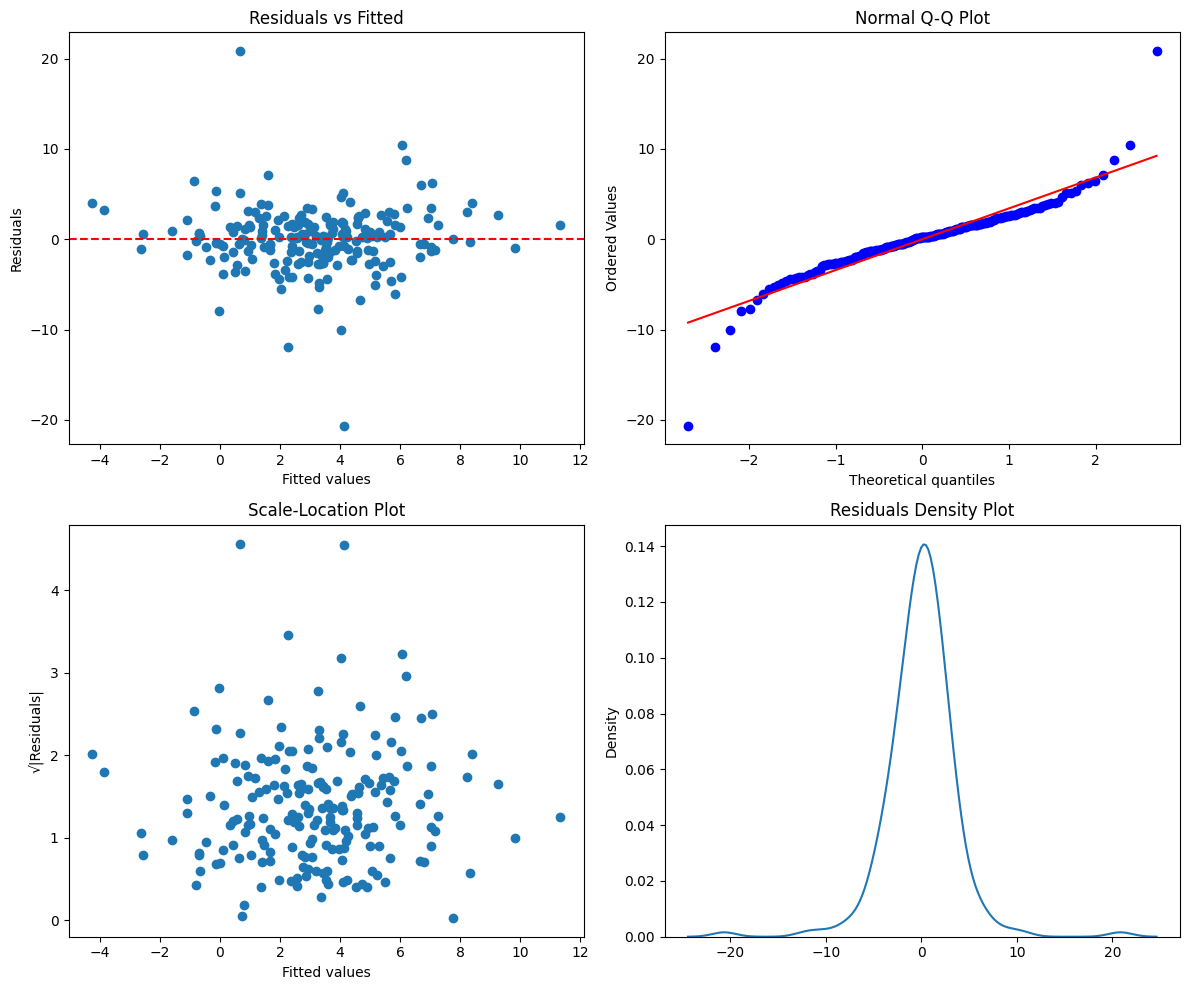

In [3]:
# Example usage
if __name__ == "__main__":
    # Generate sample data with heteroskedasticity and leverage points
    np.random.seed(42)
    n = 200
    
    # True parameters
    beta_true = np.array([3, 0.5, -1, 2])
    sigma_true = 2
    
    # Generate predictors with some extreme values
    X = np.random.normal(0, 1, (n, 3))
    X[0:5, :] = X[0:5, :] * 3  # Create some leverage points
    
    # Generate response with heteroskedastic errors
    # The variance increases with X1 and we add some outliers
    y = beta_true[0] + X @ beta_true[1:] + \
        np.random.normal(0, sigma_true * (1 + 0.5 * X[:, 0]**2), n)
    
    # Create dataset
    data = np.column_stack([y, X])
    feature_names = ['Y', 'X1', 'X2', 'X3']
    
    # Fit regular model first
   
    model_results = mle_model(data, feature_names)
    
    # Calculate HC2 robust standard errors
    robust_results = robust_se_hc2(data, model_results, feature_names)
    
    # Print results
    print(robust_results['summary'])
    
    
   